## P1 Data Exploration & Visualisation
Topics tackled in this lab: 
1. Load the data and find attribute information
2. Generate a statistical summary
3. Generate correlation matrix and scatter plot
4. Dealing with Categorical data
5. Dealing with missing values
6. Find most correlated attributes to output label

## Setup

In [4]:
# Scikit-Learn
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os  # Miscallaneous operating system interfaces

# To plot pretty figues
%matplotlib inline 
# the above sets the backend of matplotlib to the 'inline' backend
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_figure(figure_id, tight_layout=True, figure_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, figure_id + '.' + figure_extension)
    print("Saving figure", figure_id)
    if tight_layout:
        plt.tight_layout
    plt.savefig(path, format=figure_extension, dpi=resolution)

## Get the Data
### Fetch the Data

In [7]:
import os
import tarfile  # makes it possible to read and write tar archives (utility to collect many files into an archive file)
import urllib.request 

WINE_PATH = '../data\winemag-data-130k-v2.csv'

def load_data(path=WINE_PATH):
    return pd.read_csv(path)

wines = load_data()
wines.head()


AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [ ]:
wines = wines.drop('Unnamed: 0', axis=1)
wines.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [ ]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129970 entries, 1 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129907 non-null  object 
 1   description            129970 non-null  object 
 2   designation            92505 non-null   object 
 3   points                 129970 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129907 non-null  object 
 6   region_1               108723 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103726 non-null  object 
 9   taster_twitter_handle  98757 non-null   object 
 10  title                  129970 non-null  object 
 11  variety                129969 non-null  object 
 12  winery                 129970 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [ ]:
wines['province'].value_counts()  # Returns a Series containing counts of unique values.

California        36247
Washington         8639
Bordeaux           5941
Tuscany            5897
Oregon             5373
                  ...  
Messinia              1
Markopoulo            1
Paardeberg            1
Krania Olympus        1
Neuchâtel             1
Name: province, Length: 425, dtype: int64

In [ ]:
wines.describe()  # Generates descriptive statistics.

,points,price
count,129970.000000,120975.000000
mean,88.447149,35.363389
std,3.039739,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


Saving figure attribute_histogram_plots


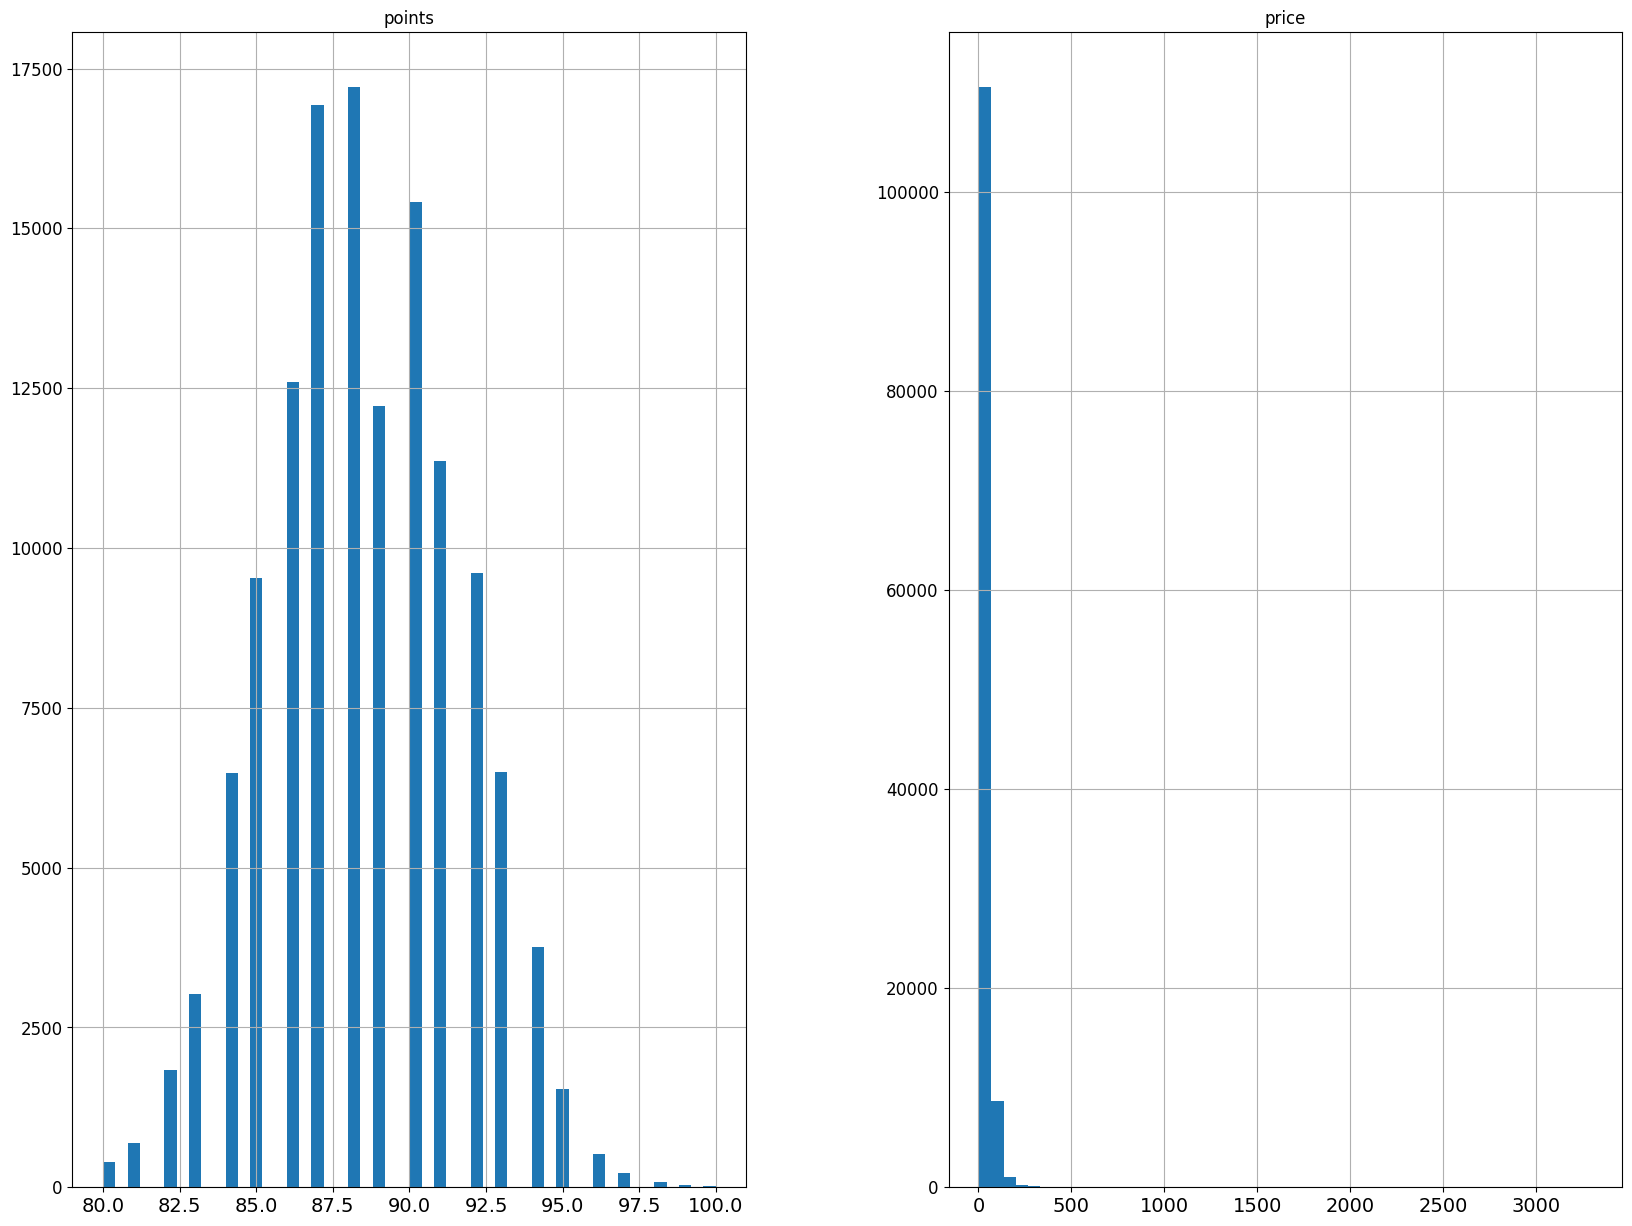

In [ ]:
wines.hist(bins=50, figsize=(20, 15))
save_figure('attribute_histogram_plots')
plt.show()

## Create a Test Set
We're splitting the data into a training and test data.

In [ ]:
np.random.seed(42)  # To make this notebook's output identical at every run.

# Illustrating the train_test_split() of Sklearn.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))  # Randomly permute a sequence, or return a permuted range.
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(wines, 0.2)
len(train_set)

103976

In [ ]:
len(test_set)

25994

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
wines_with_id = wines.reset_index()  # Add an index column. 
train_set, test_set = split_train_test_by_id(wines_with_id, 0.2, 'index')
test_set.head()

,index,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
4,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
11,12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
15,16,Argentina,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,NaN,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque
22,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi


In [ ]:
wines['price']

NameError: name 'wines' is not defined